In [2]:
from datetime import datetime
import ast

from utils import *
from config import *
from processing_utils import *
import logging

# Workflow

1. Merge diagnosis and encounter tables
2. Create lists for dx_codes
3. Get death information
4. Re-calculate hospitalization days admitted patients
5. Get immunization information
6. Filter patients with immunization

# Filter admitted patients using diagnosis and encounter tables

In [ ]:
# 

In [2]:
diagnosis_path = os.path.join(COVID_MERGED_DATA_PATH, 'diagnosis.csv')
diagnosis_copy = load_data(diagnosis_path)

In [3]:
diagnosis = diagnosis_copy.copy()
diagnosis = diagnosis[diagnosis['enc_type'].isin(admission_enc_type_list)]
diagnosis.drop(columns=['enc_type'], inplace=True)
unique_patients = diagnosis['patient_num'].unique()
# This is also including the patients who have no diagnosis code of covid
print('There are {} unique patients in the COVID-19 data set (2020-2023).'.format(len(unique_patients)))

There are 47978 unique patients in the COVID-19 data set (2020-2023).


In [4]:
encounters_path = os.path.join(COVID_MERGED_DATA_PATH, 'encounters.csv')
encounters_copy = load_data(encounters_path)

In [5]:
encounters = encounters_copy.copy()
l=['IP','ED','UN','OS']
encounters = encounters[encounters['enc_type'].isin(l)]
encounters.drop(columns=['enc_type'], inplace=True)
encounters.shape

(191036, 8)

In [6]:
diag_enc_merge = diagnosis.merge(encounters, on=['patient_num', 'encounter_num'], how='left')
# Drop rows where 'discharge_status_c' and 'admit_date_shifted' are null
diag_enc_merge = diag_enc_merge[diag_enc_merge['admit_date_shifted'].notnull()]
diag_enc_merge = diag_enc_merge[diag_enc_merge['discharge_status_c'].notnull()]
diag_enc_merge = diag_enc_merge.sort_values(by=['patient_num', 'dx_date_shifted'], ascending=True)

diag_enc_merge.isnull().sum()

patient_num                   0
encounter_num                 0
dx_date_shifted               0
dx_code                       0
age_at_visit_years            0
discharge_status_c            0
payor_type_primary_name    3691
admit_date_shifted            0
discharge_date_shifted     2581
length_of_stay_days           0
dtype: int64

In [7]:


if not os.path.exists(os.path.join(PROCESSED_DATA_PATH, 'dx_code_list.csv')):
    print(f'Not exists.')
    # group by patient_num and encounter_num amd create a new column named 'dx_code_list'
    # drop duplicates of patient_num and encounter_num
    diag_enc_merge['dx_code_list'] = diag_enc_merge.groupby(['patient_num', 'encounter_num'])['dx_code'].transform(lambda x: ', '.join(x))
    diag_enc_merge['dx_code_list'] = diag_enc_merge['dx_code_list'].apply(lambda x: list(set(x.split(', '))))
    diag_enc_merge = diag_enc_merge.drop_duplicates(subset=['patient_num', 'encounter_num'])
    
    # # save dx_code_list to csv
    save_processed_data(diag_enc_merge[['patient_num', 'encounter_num', 'dx_code_list']], 'dx_code_list', data_path=PROCESSED_DATA_PATH)
else:
    print('Start merging')
    dx_code_list_df = load_processed_data('dx_code_list')
    diag_enc_merge = diag_enc_merge.drop_duplicates(subset=['patient_num', 'encounter_num'])
    diag_enc_merge = diag_enc_merge.merge(dx_code_list_df, on=['patient_num', 'encounter_num'])
    
diag_enc_merge = diag_enc_merge.drop(['dx_code'], axis=1)


Start merging


In [8]:
diag_enc_merge

,patient_num,encounter_num,dx_date_shifted,age_at_visit_years,discharge_status_c,payor_type_primary_name,admit_date_shifted,discharge_date_shifted,length_of_stay_days,dx_code_list
0,16777551,230789668,2021-08-18 13:22:00,66,HO,MEDICARE,2021-08-18 13:22:00,2021-08-18 16:50:00,1.0,"['R55', 'S50.312A', 'E78.2', 'Z87.891', 'S90.4..."
1,16777551,172656352,2022-09-15 21:19:00,67,HO,MEDICARE,2022-09-15 21:19:00,2022-09-16 14:31:00,1.0,"['E78.5', 'Z23', 'K92.2', 'B20', 'N17.9', 'D64..."
2,16777685,144353253,2020-12-21 20:17:00,65,HO,Managed Care (Private),2020-12-21 20:17:00,2020-12-25 16:54:00,4.0,"['R00.0', 'E43', 'K40.90', 'Z23', 'E78.00', 'F..."
3,16777685,171297129,2020-12-27 14:56:00,65,HO,Managed Care (Private),2020-12-27 14:56:00,2021-01-04 08:46:00,8.0,"['N17.9', 'Z86.19', 'Z86.718', 'K40.90', 'E78...."
4,16778374,136581620,2022-07-13 06:35:00,32,HO,Managed Care (Private),2022-07-13 06:35:00,2022-07-16 12:22:00,3.0,"['O69.0XX0', 'O69.0XX1', 'Z3A.40', 'Z37.0', 'Z..."
...,...,...,...,...,...,...,...,...,...,...
122524,70484423,254680619,2022-10-14 23:33:00,22,HO,Managed Care (Private),2022-10-14 23:33:00,2022-10-15 01:14:00,1.0,"['Z20.822', 'T88.7XXA', 'R21', 'N30.01', 'R68...."
122525,73671308,316066435,2022-01-08 12:53:00,30,HO,Managed Care (Private),2022-01-08 12:53:00,2022-01-08 14:14:00,1.0,"['S06.0X0A', 'M25.511', 'R51.9']"
122526,77935325,114584299,2019-06-27 13:58:00,30,HO,Medicaid HMO,2019-06-27 13:58:00,2019-06-27 17:12:00,1.0,"['O76', 'Z3A.38', 'O24.32', 'O77.0', 'E66.01',..."
122527,77935325,92667355,2019-06-27 19:44:00,30,HO,Medicaid HMO,2019-06-27 19:44:00,2019-06-30 12:16:00,3.0,"['O76', 'Z3A.38', 'O24.919', 'O77.0', 'O24.32'..."


In [9]:
# Change the data type of 'xxx_date_shift' to datetime
diag_enc_merge['dx_date_shifted'] = pd.to_datetime(diag_enc_merge['dx_date_shifted'])
diag_enc_merge['admit_date_shifted'] = pd.to_datetime(diag_enc_merge['admit_date_shifted'])
diag_enc_merge['discharge_date_shifted'] = pd.to_datetime(diag_enc_merge['discharge_date_shifted'])

# Drop the rows where 'dx_date_shifted' before date 2020-03-01
diag_enc_merge = diag_enc_merge[diag_enc_merge['dx_date_shifted'] > datetime(2020, 3, 1)]


In [10]:
# Change the data type of 'xxx_date_shift' to datetime
diag_enc_merge['dx_date_shifted'] = pd.to_datetime(diag_enc_merge['dx_date_shifted']).dt.date
diag_enc_merge['admit_date_shifted'] = pd.to_datetime(diag_enc_merge['admit_date_shifted']).dt.date
diag_enc_merge['discharge_date_shifted'] = pd.to_datetime(diag_enc_merge['discharge_date_shifted']).dt.date


/var/folders/hv/w9cj1y9x3y38xrfqrbvdc3y00000gn/T/ipykernel_31250/3755995550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_enc_merge['dx_date_shifted'] = pd.to_datetime(diag_enc_merge['dx_date_shifted']).dt.date
/var/folders/hv/w9cj1y9x3y38xrfqrbvdc3y00000gn/T/ipykernel_31250/3755995550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_enc_merge['admit_date_shifted'] = pd.to_datetime(diag_enc_merge['admit_date_shifted']).dt.date
/var/folders/hv/w9cj1y9x3y38xrfqrbvdc3y00000gn/T/ipykernel_312

In [11]:
diag_enc_merge.head(20)

,patient_num,encounter_num,dx_date_shifted,age_at_visit_years,discharge_status_c,payor_type_primary_name,admit_date_shifted,discharge_date_shifted,length_of_stay_days,dx_code_list
0,16777551,230789668,2021-08-18,66,HO,MEDICARE,2021-08-18,2021-08-18,1.0,"['R55', 'S50.312A', 'E78.2', 'Z87.891', 'S90.4..."
1,16777551,172656352,2022-09-15,67,HO,MEDICARE,2022-09-15,2022-09-16,1.0,"['E78.5', 'Z23', 'K92.2', 'B20', 'N17.9', 'D64..."
2,16777685,144353253,2020-12-21,65,HO,Managed Care (Private),2020-12-21,2020-12-25,4.0,"['R00.0', 'E43', 'K40.90', 'Z23', 'E78.00', 'F..."
3,16777685,171297129,2020-12-27,65,HO,Managed Care (Private),2020-12-27,2021-01-04,8.0,"['N17.9', 'Z86.19', 'Z86.718', 'K40.90', 'E78...."
4,16778374,136581620,2022-07-13,32,HO,Managed Care (Private),2022-07-13,2022-07-16,3.0,"['O69.0XX0', 'O69.0XX1', 'Z3A.40', 'Z37.0', 'Z..."
5,16779256,167172872,2022-08-19,79,HO,Medicare HMO,2022-08-19,2022-08-19,1.0,['B37.89']
8,16779605,205707007,2022-02-19,53,HO,MEDICARE,2022-02-19,2022-02-20,1.0,"['R07.9', 'R11.2', 'R10.31', 'N17.9', 'R07.89'..."
9,16779605,266877621,2022-02-22,53,HO,MEDICARE,2022-02-22,2022-02-22,1.0,"['D57.3', 'R07.89', 'M79.7', 'R94.31', 'Z01.89..."
10,16779605,121910904,2022-10-16,54,HO,MEDICARE,2022-10-16,2022-10-17,1.0,"['R07.9', 'E78.5', 'R07.89', 'M79.7', 'R94.31'..."
11,16779940,106511165,2021-12-23,55,HO,MEDICARE,2021-12-23,2021-12-23,1.0,['R06.02']


In [12]:
save_processed_data(diag_enc_merge, 'diag_enc_merge_original')

# Re-calculate hospitalization

In [13]:
diag_enc_merge['dx_date_shifted'] = pd.to_datetime(diag_enc_merge['dx_date_shifted'])
diag_enc_merge['admit_date_shifted'] = pd.to_datetime(diag_enc_merge['admit_date_shifted'])
diag_enc_merge['discharge_date_shifted'] = pd.to_datetime(diag_enc_merge['discharge_date_shifted'])

/var/folders/hv/w9cj1y9x3y38xrfqrbvdc3y00000gn/T/ipykernel_31250/194364368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_enc_merge['dx_date_shifted'] = pd.to_datetime(diag_enc_merge['dx_date_shifted'])
/var/folders/hv/w9cj1y9x3y38xrfqrbvdc3y00000gn/T/ipykernel_31250/194364368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_enc_merge['admit_date_shifted'] = pd.to_datetime(diag_enc_merge['admit_date_shifted'])
/var/folders/hv/w9cj1y9x3y38xrfqrbvdc3y00000gn/T/ipykernel_31250/194364368.py:3:

In [14]:
diag_enc_merge_los = diag_enc_merge.copy()
diag_enc_merge_los.dropna(subset=['admit_date_shifted'], inplace=True)
diag_enc_merge_los.dropna(subset=['discharge_date_shifted'], inplace=True)
diag_enc_merge_los.sort_values(["patient_num", "admit_date_shifted"], inplace=True)
print(diag_enc_merge_los['admit_date_shifted'].isnull().sum())
print(diag_enc_merge_los['discharge_date_shifted'].isnull().sum())

0
0


In [15]:
print('Processing data ...')
diag_enc_merge_recalculate = count_los(diag_enc_merge_los)
save_processed_data(diag_enc_merge_recalculate, 'diag_enc_merge_covid_los_recalculate')
print('Data saved successfully!')


Processing data ...
Data saved successfully!


# Process Immunization Data

In [16]:
# Read immunization.csv
immunization_path = os.path.join(COVID_MERGED_DATA_PATH, 'immunization.csv')
immunization_df_copy = load_data(immunization_path)
immunization_df_copy.shape

(225457, 5)

In [17]:
immu_df = immunization_df_copy.copy()
immu_df = immu_df[immu_df['immnztn_status_name'] == 'Given']
immu_df = immu_df[immu_df['immunization_name'].str.contains('|'.join(immunization_name), na=False, case=False)]
immu_df = immu_df[immu_df['immune_date_shifted'].notnull()]
immu_df = immu_df.drop_duplicates(subset=['patient_num', 'encounter_num'], keep='first')

In [18]:
immu_df = immu_df[immunization_columns].astype(str)
immu_df['immune_date_shifted'] = pd.to_datetime(immu_df['immune_date_shifted'], format='%Y-%m-%d %H:%M:%S').dt.date

In [19]:
def set_mfg(x: str):
    if 'PFIZER' in x:
        return 'PFIZER'
    elif 'MODERNA' in x:
        return 'MODERNA'
    elif 'JANSSEN' in x:
        return 'JANSSEN'
    else:
        return 'Others'
immu_df['immu_mfg'] = immu_df['immunization_name'].apply(set_mfg)
immu_df = immu_df.drop(columns=['immunization_name']).sort_values(by=['patient_num', 'immune_date_shifted'])

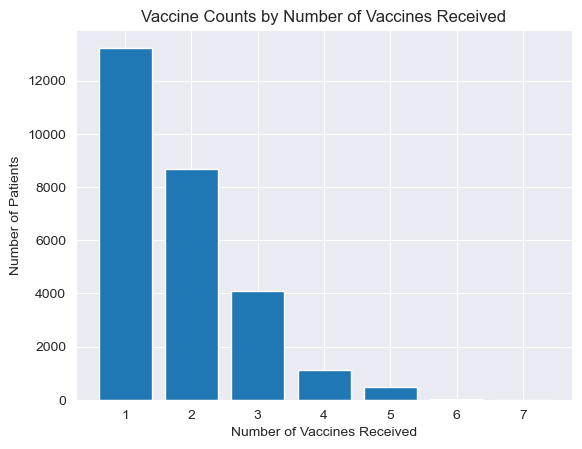

In [20]:
# Count the number of vaccines received by each patient
vaccine_counts = immu_df.groupby('patient_num').size().reset_index(name='count')

# Count the patients receiving 1, 2, 3, or more vaccines
count_summary = vaccine_counts['count'].value_counts().sort_index()

# Plot the bar chart
plt.bar(count_summary.index, count_summary.values)

# Add labels and title
plt.xlabel('Number of Vaccines Received')
plt.ylabel('Number of Patients')
plt.title('Vaccine Counts by Number of Vaccines Received')

# Display the chart
plt.savefig(os.path.join(RESULTS, 'Vaccine Counts.png'), bbox_inches='tight')
plt.show()

# Add vaccination info

## Get full vaccination date

In [21]:
def get_vaccine_fulfillment_date(group):
    group = group.sort_values('immune_date_shifted')
    if any(group['immu_mfg'] == 'JANSSEN'):
        return group.loc[group['immu_mfg'] == 'JANSSEN', 'immune_date_shifted'].iloc[0]
    else:
        if group['immu_mfg'].isin(['MODERNA', 'PFIZER']).sum() >= 2:
            return group.loc[group['immu_mfg'].isin(['MODERNA', 'PFIZER']), 'immune_date_shifted'].iloc[1]
    return pd.NaT

immu_df['immune_date_shifted'] = pd.to_datetime(immu_df['immune_date_shifted'])
df_sorted = immu_df.sort_values(['patient_num', 'immune_date_shifted'])
fulfillment_dates = df_sorted.groupby('patient_num').apply(get_vaccine_fulfillment_date).dropna().reset_index()
fulfillment_dates.columns = ['patient_num', 'date_of_full_vaccination']

In [22]:
save_processed_data(fulfillment_dates, 'date_of_full_vaccination')

## Filter patients with vaccine information

In [23]:
all_patient = load_processed_data('diag_enc_merge_covid_los_recalculate')
full_dates = load_processed_data('date_of_full_vaccination')

In [24]:
fulfillment_dates["patient_num"] = fulfillment_dates["patient_num"].astype(str)
all_patient["patient_num"] = all_patient["patient_num"].astype(str)

In [25]:
fully_vaccinated_patients, not_fully_vaccinated_patients = filter_vaccinated_patients(fulfillment_dates, all_patient)

In [26]:
patients_with_vaccine_info = pd.concat([fully_vaccinated_patients, not_fully_vaccinated_patients])

In [27]:
patients_with_vaccine_info.head(20)

,patient_num,encounter_num,dx_date_shifted,age_at_visit_years,discharge_status_c,payor_type_primary_name,admit_date_shifted,discharge_date_shifted,length_of_stay_days,dx_code_list,encounter_list,total_length_of_stay,date_of_full_vaccination,admission_after_vaccine
0,16777551,172656352,2022-09-15,67,HO,MEDICARE,2022-09-15,2022-09-16,1.0,"['E78.5', 'Z23', 'K92.2', 'B20', 'N17.9', 'D64...",[172656352],2,2022-05-17,Yes
34,16783637,191030086,2022-08-27,52,HO,"Private health insurance, other commercial Ind...",2022-08-27,2022-08-27,1.0,"['R30.0', 'R39.9']",[191030086],1,2021-05-11,Yes
55,16788105,177930477,2021-06-26,30,HO,Managed Care (Private),2021-06-26,2021-06-27,1.0,"['R19.7', 'N12', 'R31.9', 'Z32.02', 'N10']",[177930477],2,2021-04-30,Yes
56,16788105,183232133,2022-09-16,31,HO,Managed Care (Private),2022-09-16,2022-09-16,1.0,"['Z34.90', 'R10.9', 'Z3A.35', 'O26.893']",[183232133],1,2021-04-30,Yes
57,16788105,216484449,2022-10-15,32,HO,Managed Care (Private),2022-10-15,2022-10-17,2.0,"['O72.1', 'Z20.822', 'O76', 'Z3A.39', 'Z34.90'...",[216484449],3,2021-04-30,Yes
79,16792607,177135961,2022-10-03,57,HO,MEDICARE,2022-10-03,2022-10-03,1.0,"['R07.81', 'M79.601']",[177135961],1,2022-01-18,Yes
111,16800876,174106015,2022-02-26,63,HO,Managed Care (Private),2022-02-26,2022-02-26,1.0,"['Z79.4', 'I10', 'W19.XXXA', 'M25.511', 'Z79.82']",[174106015],1,2021-09-28,Yes
117,16804086,127285600,2022-08-16,87,SH,MEDICARE,2022-08-16,2022-08-17,1.0,"['R79.89', 'I10', 'Z79.899', 'R10.33']","[127285600, 173092473]",2,2021-03-25,Yes
118,16804189,120194091,2022-05-19,66,HO,Managed Care (Private),2022-05-19,2022-05-19,1.0,"['M54.50', 'J45.909', 'K21.9', 'E03.9']",[120194091],1,2021-02-14,Yes
129,16805691,176082653,2022-07-29,75,HO,MEDICARE,2022-07-29,2022-07-30,1.0,"['E78.5', 'E86.0', 'I48.91', 'Z86.73', 'Z20.82...",[176082653],2,2021-03-12,Yes


## Drop unnecessary columns

In [28]:
patients_with_vaccine_info.columns

Index(['patient_num', 'encounter_num', 'dx_date_shifted', 'age_at_visit_years',
       'discharge_status_c', 'payor_type_primary_name', 'admit_date_shifted',
       'discharge_date_shifted', 'length_of_stay_days', 'dx_code_list',
       'encounter_list', 'total_length_of_stay', 'date_of_full_vaccination',
       'admission_after_vaccine'],
      dtype='object')

In [29]:
neglect_columns = ['encounter_list', 'date_of_full_vaccination', 'length_of_stay_days']
all_patients = patients_with_vaccine_info.drop(columns=neglect_columns)
save_processed_data(all_patients, 'all_patients_with_dxcode_vaccine_info')